<a href="https://colab.research.google.com/github/345ishaan/algorithmic_trading/blob/main/Stock_Mode_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install Dependencies
!pip install jugaad-data
!pip install pandas
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.8/115.8 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.3
    Uninstalling click-8.1.3:
      Successfully uninstalled click-8.1.3
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling beautifulsoup4-4.11.2:
      Successfully uninstalled beautifulsoup4-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 2.2.4 requires click>=8.0, but you have click 7.1.2 which is incompatible.
pip-tools 6.13.0 requires click>=8, but you have click 7.1.2 which is incompatible.
yfinance 0.2.18 requires beautifulsoup4>=4.11.1, but you have bea

In [2]:
from jugaad_data.nse import stock_df
import collections
from datetime import datetime
import numpy as np
import yfinance as yf
from calendar import monthrange
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import requests
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [3]:
# Maps famous NSE indices to their data files on nseindia
NSE_INDEX_TO_CSV = {
    'NIFTY_50': 'https://raw.githubusercontent.com/345ishaan/algorithmic_trading/main/nifty_50.csv',
    'NIFTY_LARGEMIDCAP_250': 'https://raw.githubusercontent.com/345ishaan/algorithmic_trading/main/nifty_largemidcap_250.csv',
    'NIFTY_MIDSMALLCAP_400': 'https://raw.githubusercontent.com/345ishaan/algorithmic_trading/main/nifty_midsmallcap_400.csv',
}

In [4]:
def tickers_in_index(url_path):
  res = requests.get(url_path, allow_redirects=True)
  with open('data.csv','wb') as file:
    file.write(res.content)
  df = pd.read_csv('data.csv')
  return np.array(df['SYMBOL \n'][1:].values).tolist() 

In [5]:
#@title Params
start_year = 2012 #@param {type:"integer"}
end_year = 2022 #@param {type:"integer"}
index_name = 'NIFTY_LARGEMIDCAP_250' #@param

In [6]:
stock_tickers = tickers_in_index(NSE_INDEX_TO_CSV[index_name])
stock_tickers = list(map(lambda x : x +'.NS' , stock_tickers))

In [7]:
stock_data = yf.download(" ".join(stock_tickers), start="2012-01-01", end="2022-12-31")


[*********************100%***********************]  250 of 250 completed


In [8]:
stock_data['Open']['RELIANCE.NS'][:15]

Date
2012-01-02    345.128540
2012-01-03    352.780975
2012-01-04    360.284851
2012-01-05    354.143066
2012-01-06    345.252350
2012-01-09    353.870667
2012-01-10    352.657166
2012-01-11    365.485565
2012-01-12    370.240479
2012-01-13    367.516327
2012-01-16    361.547882
2012-01-17    354.638397
2012-01-18    377.422424
2012-01-19    390.795654
2012-01-20    391.290955
Name: RELIANCE.NS, dtype: float64

In [9]:
#@title Find average month change over past xx years
PCT_DATA = {}
for stock in stock_tickers:
  PCT_DATA[stock] = {}
  month_ch = collections.defaultdict(list)
  month_valid = collections.defaultdict(list)
  for year in range(start_year, end_year + 1):
    # TODO: check if we query change without asking all info in a dataframe.
    for m in range(1, 12+1):
      num_days = monthrange(year, m)[1]
      week_day_end = datetime(year,m,num_days).weekday()
      valid_start = 1
      valid_open = None
      valid_end = num_days
      valid_close = None
      while valid_open is None:
        try:
          str_start = f'0{valid_start}' if valid_start < 10 else f'{valid_start}'
          str_m = f'0{m}' if m < 10 else f'{m}'
          month_start = f'{year}-{str_m}-{str_start}'
          valid_open = stock_data['Open'][stock][month_start]
        except Exception as e:
          valid_start += 1
          valid_start %= num_days
      end_m = m
      while valid_close is None:
        try:
          str_end = f'0{valid_end}' if valid_end < 10 else f'{valid_end}'
          str_m = f'0{end_m}' if end_m < 10 else f'{end_m}'
          month_end = f'{year}-{str_m}-{str_end}'
          valid_close = stock_data['Close'][stock][month_end]
        except Exception as e:
          valid_end = (valid_end + 1)% num_days
          end_m = m+1 if m + 1 < 12 else 1

      delta_change = valid_close - valid_open
      pct_change = (delta_change / valid_open)*100
      month_ch[m].append(pct_change)
      month_valid[m].append(1)
  PCT_DATA[stock]['month_ch'] = month_ch
  PCT_DATA[stock]['month_valid'] = month_valid

In [10]:
print(PCT_DATA['TORNTPHARM.NS']['month_ch'][1])

[1.274530049993312, -3.5606026977875342, 14.214604036918738, 0.8533311631944445, -4.3838618350381005, -1.3058552878089187, -3.988722733328929, 1.9535356153549601, 4.108035482718026, -9.590060796061, -18.51609116449977]


Text(0, 0.5, '%change')

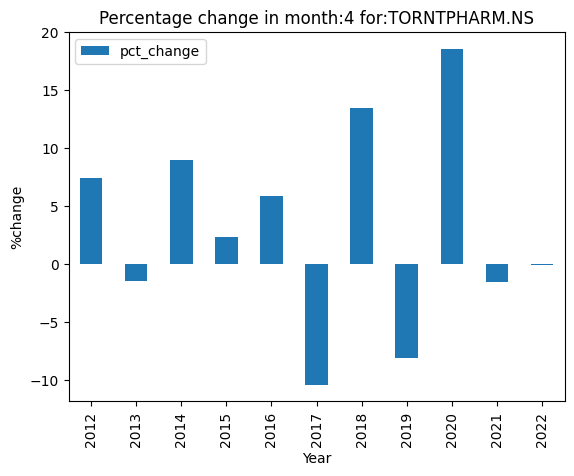

In [11]:
#@title Plot per month bar plot given stock symbol

plot_stock_symbol = 'TORNTPHARM.NS' #@param {type:"string"}
plot_month = 4 #@param
plotdata = pd.DataFrame([{'pct_change': PCT_DATA[plot_stock_symbol]['month_ch'][plot_month][x], } for x,_ in enumerate(range(start_year, end_year + 1))],
                        index=[year for year in range(start_year, end_year + 1)])
plotdata.plot(kind="bar")
plt.title(f"Percentage change in month:{plot_month} for:{plot_stock_symbol}")
plt.xlabel("Year")
plt.ylabel("%change")

In [12]:
#@title Find stock months where PCT_Change > threshold more than x% of year range.

YEAR_X = 1.0 #@param
PCT_THRESHOLD = 5 #@param
MONTH_RANGE = range(1,13)
FILTERED_STOCKS = []
for stock in PCT_DATA:
  max_num = 0
  max_month = None
  for month in MONTH_RANGE:
    month_ch = np.array(PCT_DATA[stock]['month_ch'][month])
    total_months = np.sum(np.array(month_ch > PCT_THRESHOLD))
    if max_num < total_months:
      max_month = month
      max_num = total_months
  # max_month / max_num
  # Feb: 10 March : 8 Jun: 6
  # max_month = Feb
  # max_num = 10
  # max_num >= percentage of year_range:
  if max_num >= YEAR_X*(end_year-start_year):
    FILTERED_STOCKS.append({'ticker': stock, 'best_month': max_month, 'count': max_num})
print(FILTERED_STOCKS)
  

[{'ticker': 'TORNTPHARM.NS', 'best_month': 7, 'count': 10}]
